<a href="https://colab.research.google.com/github/SatioO/DL_Practices/blob/master/Image_Segmentation_FCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import cv2
import random
import itertools
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tqdm import tqdm
from google.colab.patches import cv2_imshow

tf.random.set_seed(0)
random.seed(0)

In [0]:
# from google.colab import drive
# drive.mount('/content/drive')

In [0]:
# !unzip drive/My\ Drive/Launch\ pad/dataset1.zip

In [0]:
TRAIN_IMG_PATH = "dataset1/images_prepped_train/"
TRAIN_ANNOT_PATH = "dataset1/annotations_prepped_train/"
TEST_IMG_PATH = "dataset1/images_prepped_test/"
TEST_ANNOT_PATH = "dataset1/annotations_prepped_test/"

BATCH_SIZE = 32 #@param {type: "number"}
BUFFER_SIZE = 2000 #@param {type: "number"}
TRAIN_LENGTH = 800 #@param {type: "number"}
DROPOUT_RATE = 0.4  #@param {type: "number"}
NUM_CHANNELS = 11 #@param {type: "number"}

IMG_HEIGHT = 224
IMG_WIDTH = 224

train_x = tf.data.Dataset.list_files(TRAIN_IMG_PATH + "*.png")
train_y = tf.data.Dataset.list_files(TRAIN_ANNOT_PATH + "*.png")
test_x = tf.data.Dataset.list_files(TEST_IMG_PATH + "*.png")
test_y = tf.data.Dataset.list_files(TEST_ANNOT_PATH + "*.png")

In [5]:
class DataLoaderError(Exception):
    pass

def get_pairs_from_paths(images_path, segs_path, ignore_non_matching=False):
    """ Find all the images from the images_path directory and
        the segmentation images from the segs_path directory
        while checking integrity of data """

    ACCEPTABLE_IMAGE_FORMATS = [".jpg", ".jpeg", ".png", ".bmp"]
    ACCEPTABLE_SEGMENTATION_FORMATS = [".png", ".bmp"]

    image_files = []
    segmentation_files = {}

    for dir_entry in os.listdir(images_path):
        if os.path.isfile(os.path.join(images_path, dir_entry)) and \
                os.path.splitext(dir_entry)[1] in ACCEPTABLE_IMAGE_FORMATS:
            file_name, file_extension = os.path.splitext(dir_entry)
            image_files.append((file_name, file_extension,
                                os.path.join(images_path, dir_entry)))

    for dir_entry in os.listdir(segs_path):
        if os.path.isfile(os.path.join(segs_path, dir_entry)) and \
           os.path.splitext(dir_entry)[1] in ACCEPTABLE_SEGMENTATION_FORMATS:
            file_name, file_extension = os.path.splitext(dir_entry)
            full_dir_entry = os.path.join(segs_path, dir_entry)
            if file_name in segmentation_files:
                raise DataLoaderError("Segmentation file with filename {0}"
                                      " already exists and is ambiguous to"
                                      " resolve with path {1}."
                                      " Please remove or rename the latter."
                                      .format(file_name, full_dir_entry))

            segmentation_files[file_name] = (file_extension, full_dir_entry)

    return_value = []
    # Match the images and segmentations
    for image_file, _, image_full_path in image_files:
        if image_file in segmentation_files:
            return_value.append((image_full_path,
                                segmentation_files[image_file][1]))
        elif ignore_non_matching:
            continue
        else:
            # Error out
            raise DataLoaderError("No corresponding segmentation "
                                  "found for image {0}."
                                  .format(image_full_path))

    return return_value

def verify_segmentation_dataset(images_path, segs_path,
                                n_classes, show_all_errors=False):
    try:
        img_seg_pairs = get_pairs_from_paths(images_path, segs_path)
        if not len(img_seg_pairs):
            print("Couldn't load any data from images_path: "
                  "{0} and segmentations path: {1}"
                  .format(images_path, segs_path))
            return False

        return_value = True
        for im_fn, seg_fn in tqdm(img_seg_pairs):
          img = cv2.imread(im_fn)
          seg = cv2.imread(seg_fn)
          # Check dimensions match
          if not img.shape == seg.shape:
              return_value = False
              print("The size of image {0} and its segmentation {1} "
                    "doesn't match (possibly the files are corrupt)."
                    .format(im_fn, seg_fn))
              if not show_all_errors:
                  break
          else:
              max_pixel_value = np.max(seg[:, :, 0])
              if max_pixel_value >= n_classes:
                  return_value = False
                  print("The pixel values of the segmentation image {0} "
                        "violating range [0, {1}]. "
                        "Found maximum pixel value {2}"
                        .format(seg_fn, str(n_classes - 1), max_pixel_value))
                  if not show_all_errors:
                      break
        if return_value:
            print("Dataset verified! ")
        else:
            print("Dataset not verified!")
        return return_value

    except DataLoaderError as e:
        print("Found error during data loading\n{0}".format(str(e)))
        return False

verify_segmentation_dataset(TEST_IMG_PATH, TEST_ANNOT_PATH, 51)

100%|██████████| 101/101 [00:00<00:00, 177.71it/s]

Dataset verified! 


True

Found the following classes in the segmentation image: [ 0  1  2  3  4  5  6  7  8  9 10 11]


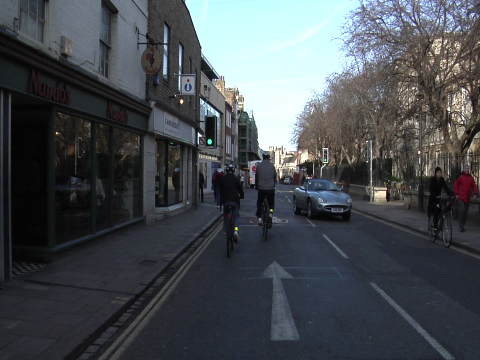

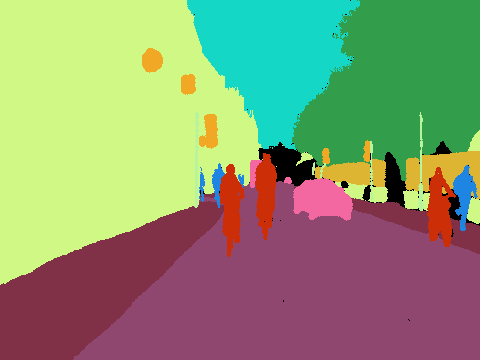

In [6]:
class_colors = [(random.randint(0, 255), random.randint(
    0, 255), random.randint(0, 255)) for _ in range(5000)]


def _get_colored_segmentation_image(img, seg, colors,
                                    n_classes, do_augment=False):
    """ Return a colored segmented image """
    seg_img = np.zeros_like(seg)

    if do_augment:
        img, seg[:, :, 0] = augment_seg(img, seg[:, :, 0])

    for c in range(n_classes):
        seg_img[:, :, 0] += ((seg[:, :, 0] == c)
                             * (colors[c][0])).astype('uint8')
        seg_img[:, :, 1] += ((seg[:, :, 0] == c)
                             * (colors[c][1])).astype('uint8')
        seg_img[:, :, 2] += ((seg[:, :, 0] == c)
                             * (colors[c][2])).astype('uint8')

    return img, seg_img

def visualize_segmentation_dataset(images_path, segs_path, n_classes,
                                   do_augment=False, ignore_non_matching=False,
                                   no_show=False):
    try:
        # Get image-segmentation pairs
        img_seg_pairs = get_pairs_from_paths(
                            images_path, segs_path,
                            ignore_non_matching=ignore_non_matching)

        # Get the colors for the classes
        colors = class_colors

        im_fn, seg_fn = img_seg_pairs[0]
        img = cv2.imread(im_fn)
        seg = cv2.imread(seg_fn)
        print("Found the following classes in the segmentation image:",
              np.unique(seg))
        img, seg_img = _get_colored_segmentation_image(
                                                img, seg, colors,
                                                n_classes,
                                                do_augment=do_augment)
        cv2_imshow(img)
        cv2_imshow(seg_img)
    except DataLoaderError as e:
        print("Found error during data loading\n{0}".format(str(e)))
        return False

visualize_segmentation_dataset(TEST_IMG_PATH, TEST_ANNOT_PATH, 11)

In [0]:
def get_image_array(image_input,
                    width, height,
                    imgNorm="sub_mean", ordering='channels_first'):
    """ Load image array from input """

    if type(image_input) is np.ndarray:
        # It is already an array, use it as it is
        img = image_input
    elif isinstance(image_input, str):
        if not os.path.isfile(image_input):
            raise DataLoaderError("get_image_array: path {0} doesn't exist"
                                  .format(image_input))
        img = cv2.imread(image_input, 1)
    else:
        raise DataLoaderError("get_image_array: Can't process input type {0}"
                              .format(str(type(image_input))))

    if imgNorm == "sub_and_divide":
        img = np.float32(cv2.resize(img, (width, height))) / 127.5 - 1
    elif imgNorm == "sub_mean":
        img = cv2.resize(img, (width, height))
        img = img.astype(np.float32)
        img[:, :, 0] -= 103.939
        img[:, :, 1] -= 116.779
        img[:, :, 2] -= 123.68
        img = img[:, :, ::-1]
    elif imgNorm == "divide":
        img = cv2.resize(img, (width, height))
        img = img.astype(np.float32)
        img = img/255.0

    # if ordering == 'channels_first':
    #     img = np.rollaxis(img, 2, 0)
    return img


def get_segmentation_array(image_input, nClasses,
                           width, height, no_reshape=True):
    """ Load segmentation array from input """

    seg_labels = np.zeros((height, width, nClasses))

    if type(image_input) is np.ndarray:
        # It is already an array, use it as it is
        img = image_input
    elif isinstance(image_input, str):
        if not os.path.isfile(image_input):
            raise DataLoaderError("get_segmentation_array: "
                                  "path {0} doesn't exist".format(image_input))
        img = cv2.imread(image_input, 1)
    else:
        raise DataLoaderError("get_segmentation_array: "
                              "Can't process input type {0}"
                              .format(str(type(image_input))))

    img = cv2.resize(img, (width, height), interpolation=cv2.INTER_NEAREST)
    img = img[:, :, 0]

    for c in range(nClasses):
        seg_labels[:, :, c] = (img == c).astype(int)

    if not no_reshape:
        seg_labels = np.reshape(seg_labels, (width*height, nClasses))

    return seg_labels

In [0]:
def image_segmentation_generator(images_path, segs_path, batch_size,
                                 n_classes, input_height, input_width,
                                 output_height, output_width,
                                 do_augment=False,
                                 augmentation_name="aug_all"):
  
  img_seg_pairs = get_pairs_from_paths(images_path, segs_path)
  random.shuffle(img_seg_pairs)
  zipped = itertools.cycle(img_seg_pairs)

  while True:
      X = []
      Y = []
      for _ in range(batch_size):
          im, seg = next(zipped)

          im = cv2.imread(im, 1)
          seg = cv2.imread(seg, 1)

          if do_augment:
              im, seg[:, :, 0] = augment_seg(im, seg[:, :, 0],
                                              augmentation_name)

          X.append(get_image_array(im, input_width, input_height))
          Y.append(get_segmentation_array(
              seg, n_classes, output_width, output_height))

      yield np.array(X), np.array(Y)

In [0]:
# def read_image(path):
#   image = tf.io.read_file(path)
#   image = tf.image.decode_jpeg(image)
#   image = tf.image.convert_image_dtype(image, tf.float32)
#   feature = tf.image.resize(image[:, :256, :], (IMG_HEIGHT, IMG_WIDTH))
#   label = tf.image.resize(image[:, 256:, :], (IMG_HEIGHT, IMG_WIDTH))
  
#   return (feature, label)

# ds = images.map(read_image).batch(BATCH_SIZE).shuffle(BUFFER_SIZE)

# train_ds = ds.take(TRAIN_LENGTH).batch(BATCH_SIZE)
# valid_ds = ds.skip(TRAIN_LENGTH).batch(BATCH_SIZE)

In [0]:
# fig, ax = plt.subplots(1, 2, figsize=(12, 12))
# sample_image = next(iter(ds.take(1)))
# ax[0].imshow(sample_image[0][0])
# ax[1].imshow(sample_image[0][1])

In [0]:
def build_vgg16_encoder(input_shape):
  inputs = keras.layers.Input(shape=input_shape)
  # Layer 1
  e = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
  e = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(e)
  e = keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2))(e)
  e1 = e

  # Layer 2
  e = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(e)
  e = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(e)
  e = keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2))(e)
  e2 = e

  # Layer 3
  e = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(e)
  e = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(e)
  e = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(e)
  e = keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2))(e)
  e3 = e

  # Layer 4
  e = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(e)
  e = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(e)
  e = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(e)
  e = keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2))(e)
  e4 = e

  # Layer 5
  e = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(e)
  e = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(e)
  e = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(e)
  e = keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2))(e)
  e5 = e

  return inputs, [e1, e2, e3, e4, e5]

In [0]:
def crop(o1, o2, i):
  o_shape2 = keras.Model(i, o2).output_shape
  output_height2 = o_shape2[1]
  output_width2 = o_shape2[2]

  o_shape1 = keras.Model(i, o1).output_shape
  output_height1 = o_shape1[1]
  output_width1 = o_shape1[2]

  cx = abs(output_width1 - output_width2)
  cy = abs(output_height2 - output_height1)

  if output_width1 > output_width2:
      o1 = keras.layers.Cropping2D(cropping=((0, 0),  (0, cx)))(o1)
  else:
      o2 = keras.layers.Cropping2D(cropping=((0, 0),  (0, cx)))(o2)

  if output_height1 > output_height2:
      o1 = keras.layers.Cropping2D(cropping=((0, cy),  (0, 0)))(o1)
  else:
      o2 = keras.layers.Cropping2D(cropping=((0, cy),  (0, 0)))(o2)

  return o1, o2

def build_fcn8(encoder):
  # ENCODER - can be replaced with any other arch.
  inputs, [e1, e2, e3, e4, e5] = encoder(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

  # FULLY CONVOLUTIONAL LAYERS
  o = keras.layers.Conv2D(4096, (7, 7), activation='relu', padding='same')(e5)
  o = keras.layers.Dropout(DROPOUT_RATE)(o)

  o = keras.layers.Conv2D(4096, (1, 1), activation='relu', padding='same')(o)
  o = keras.layers.Dropout(DROPOUT_RATE)(o)

  o = keras.layers.Conv2D(NUM_CHANNELS, (1, 1), activation='relu', padding='same')(o) # Classifying Layer

  # DECODER
  d = keras.layers.Conv2DTranspose(NUM_CHANNELS, (4, 4), strides=(2, 2), padding='same')(o)
  d2 = keras.layers.Conv2D(NUM_CHANNELS, (1, 1))(e4)
  # d, d2 = crop(d, d2, inputs)
  d = keras.layers.Add()([d, d2]) 

  d = keras.layers.Conv2DTranspose(NUM_CHANNELS, (4, 4), strides=(2, 2), padding='same')(d)
  d2 = keras.layers.Conv2D(NUM_CHANNELS, (1, 1))(e3)
  # d, d2 = crop(d, d2, inputs)
  d = keras.layers.Add()([d, d2])

  d = keras.layers.Conv2DTranspose(NUM_CHANNELS, (16, 16), strides=(8, 8), padding='same')(d)
  outputs = keras.layers.Softmax()(d)

  return keras.Model(inputs, outputs)

In [17]:
model = build_fcn8(build_vgg16_encoder)
model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

train_gen = image_segmentation_generator(TRAIN_IMG_PATH, TRAIN_ANNOT_PATH,  32,  11, 224, 224, 224, 224)
history = model.fit_generator(train_gen, 128, epochs=10)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
128/128 [==============================] - 168s 1s/step - loss: 2.3215 - accuracy: 0.0980
Epoch 2/10
128/128 [==============================] - 171s 1s/step - loss: 2.2992 - accuracy: 0.1074
Epoch 3/10
128/128 [==============================] - 171s 1s/step - loss: 2.2903 - accuracy: 0.1163
Epoch 4/10
128/128 [==============================] - 171s 1s/step - loss: 2.2771 - accuracy: 0.1279
Epoch 5/10
128/128 [==============================] - 171s 1s/step - loss: 2.2525 - accuracy: 0.1475
Epoch 6/10
128/128 [==============================] - 171s 1s/step - loss: 2.2049 - accuracy: 0.1827
Epoch 7/10
128/128 [==============================] - 171s 1s/step - loss: 2.1133 - accuracy: 0.2324
Epoch 8/10
128/128 [==============================] - 171s 1s/step - loss: 1.9592 - accuracy: 0.3159
Epoch 9/10
128/128 [==============================] - 171s 1s/step - loss: 1.7835 - accuracy: 0.3925
Epoch 10/10
128

(224, 224, 3)


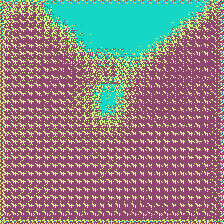

In [64]:
def get_colored_segmentation_image(seg_arr, n_classes, colors=class_colors):
    output_height = seg_arr.shape[0]
    output_width = seg_arr.shape[1]

    seg_img = np.zeros((output_height, output_width, 3))

    for c in range(n_classes):
        seg_arr_c = seg_arr[:, :] == c
        seg_img[:, :, 0] += ((seg_arr_c)*(colors[c][0])).astype('uint8')
        seg_img[:, :, 1] += ((seg_arr_c)*(colors[c][1])).astype('uint8')
        seg_img[:, :, 2] += ((seg_arr_c)*(colors[c][2])).astype('uint8')

    return seg_img

def visualize_segmentation(seg_arr, inp_img=None, n_classes=None,
                           colors=class_colors, class_names=None,
                           overlay_img=False, show_legends=False,
                           prediction_width=None, prediction_height=None):

    if n_classes is None:
        n_classes = np.max(seg_arr)

    seg_img = get_colored_segmentation_image(seg_arr, n_classes, colors=colors)

    return seg_img

def predict(img_path):
  inp = cv2.imread(img_path)
  x = get_image_array(inp, 224, 224)
  pr = model.predict(np.array([x]))[0]
  pr = pr.reshape((224,  224, 11)).argmax(axis=2)
  seg_img = visualize_segmentation(pr, inp, n_classes=11, colors=class_colors)
  print(seg_img.shape)
  return seg_img

cv2_imshow(predict(TRAIN_IMG_PATH + "/0001TP_007920.png"))